# 🌴 **RRT Planning**
In this notebook, we'll be implementing RRT in a map with different obstacles! This notebook is going to be fairly short, but will get into some of the new topics we've talked about!

In [ ]:
# imports for this notebook
import numpy as np
import matplotlib.pyplot as plt

We're going to start out by defining our environment. Our environment has a **start**, a **goal**, a list of **obstacles**, and **bounds** defining the size of the environment. 

In [ ]:
start = (11,0)
goal = (6,8)

obstacles = [ # circles are defined by [x, y, radius]
        np.array([9, 6, 2]),
        np.array([9, 8, 1]),
        np.array([9, 10, 2]),
        np.array([4, 5, 2]),
        np.array([7, 5, 2]),
        np.array([4, 10, 1])
] 

bounds = np.array([-2, 15]) # Bounds in both x and y

We also have a function we can use to plot the environment for us. Run the cell below to see what our environment looks like!

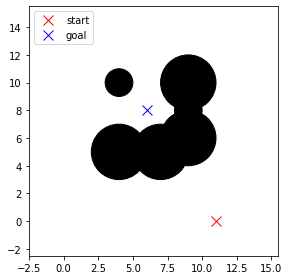

In [ ]:
def plot_scene(obstacle_list, start, goal):
    ax = plt.gca()
    for o in obstacle_list:
        circle = plt.Circle((o[0], o[1]), o[2], color='k')
        ax.add_artist(circle)
    plt.axis([bounds[0]-0.5, bounds[1]+0.5, bounds[0]-0.5, bounds[1]+0.5])
    plt.plot(start[0], start[1], "xr", markersize=10)
    plt.plot(goal[0], goal[1], "xb", markersize=10)
    plt.legend(('start', 'goal'), loc='upper left')
    plt.gca().set_aspect('equal')
    
plt.figure()
plot_scene(obstacles, np.array(start), np.array(goal))
plt.tight_layout()

Since this is open space, nodes are no longer represented by their `(row, column)` as we've seen before (space is continuous). Instead, we'll represent nodes as `(x, y)` coordinates. Since our environments are being plotted, the `(x, y)` coordinates work the same way you would be used to on a coordinate plane - i.e, `(0,0)` is the bottom left corner.

Below is a bank of functions that have been written for you to use to implement RRT below. Take a look and if you have any questions on these, ask!

In [ ]:
def is_collision(p1, p2, obstacle_list):
  ''' returns true if the point is colliding with one of the obstacles 
  or if an obstacle exists between the two points'''
  p1 = np.array(p1)
  p2 = np.array(p2)
  for o in obstacle_list:
    center_circle = o[0:2]
    radius = o[2]
    d12 = p2 - p1 # the directional vector from p1 to p2
    # defines the line v(t) := p1 + d12*t going through p1=v(0) and p2=v(1)
    d1c = center_circle - p1 # the directional vector from circle to p1
    # t is where the line v(t) and the circle are closest
    # Do not divide by zero if pt1 and pt2 are the same.
    # In that case this will still check for collisions with circles
    t = d12.dot(d1c) / (d12.dot(d12) + 1e-7)
    t = max(0, min(t, 1)) # Our line segment is bounded 0<=t<=1
    d = p1 + d12*t # The point where the line segment and circle are closest
    is_collide = np.sum(np.square(center_circle-d)) < radius**2
    if is_collide:
      return True 
  return False 

def steer(from_node, to_node, max_extend_length=np.inf):
  """Connects from_node to a new_node in the direction of to_node
  with maximum distance max_extend_length
  """
  from_node = np.array(from_node)
  to_node = np.array(to_node)
  new_node = to_node
  d = from_node - to_node
  dist = np.linalg.norm(d)
  if dist > max_extend_length:
    # rescale the path to the maximum extend_length
    new_node  = from_node - d / dist * max_extend_length
  return tuple(new_node)

def dist_to_goal(point, goal):
  """Distance from point to goal"""
  point = np.array(point)
  goal = np.array(goal)
  return np.linalg.norm(point - goal)

def get_random_node(bounds):
  """Sample random node inside bounds or sample goal point"""
  rnd = np.random.rand(2)*(bounds[1]-bounds[0]) + bounds[0]
  return tuple(rnd)

def get_nearest_node(node_list, node):
  """Find the nearest node in node_list to node"""
  dlist = [np.sum(np.square((np.array(node) - np.array(n)))) for n in node_list]
  minind = dlist.index(min(dlist))
  return node_list[minind]


def draw_graph(came_from):
  '''Draws the graph'''
  for node in came_from:
    if came_from[node]!=None:
      plt.plot([node[0], came_from[node][0]], [node[1], came_from[node][1]], "-g")

## 🌲 **Growing Trees**
Now that we have all the pieces necessary, go ahead and fill in the `RRT_tree` function below. Follow the commented pseudocode to help you write the function!

In [ ]:
def RRT_tree(start, end, bounds, obstacle_list, max_iter = 500, max_extend_length=1.0):
  '''
  Returns the tree created by RRT. Shouldn't build the tree anymore once a path can be made to the goal
  The tree should be formatted as the came_from dictionary where you're mapping children to their parents
  '''
  # initialize the node list and came from dict
  node_list = [start]
  came_from = {start:None}
  # loop until no more iterations
  for i in range(max_iter):
    # get a random node
    randNode = get_random_node_sg(bounds,end,.5)
    # find the closest node to that node
    nearNode = get_nearest_node(node_list,randNode)
    # steer from the closest node in the direction of the random node
    steerNode = steer(nearNode,randNode,max_extend_length)
    # if there's no collision between steered node and closest node
    if not(is_collision(nearNode,steerNode,obstacle_list)):
      # add it to node list and came from
      node_list.append(steerNode)
      came_from[steerNode] = nearNode
      # if this new node is less than max_extend_length to the goal
      if abs(dist_to_goal(steerNode,end)) < max_extend_length:
        # if there is no collision between the new node and goal node
        if not(is_collision(steerNode,end,obstacle_list)):
          # add it to node list and came from
          node_list.append(end)
          came_from[end] = steerNode
          # return the came from dict
          return came_from
  return None

## 🌳 **Visualizing Trees**
Once you've finished the function above, go ahead and run the cell below! This will allow us to see the tree that was made!

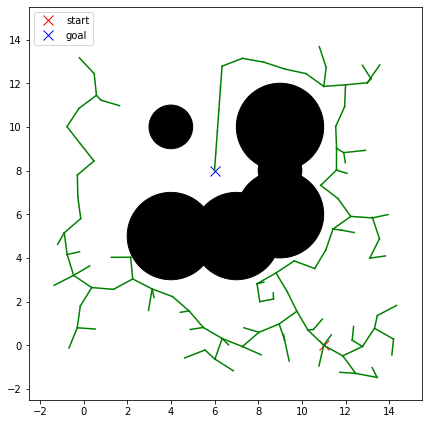

In [ ]:
np.random.seed(7)
rrt = RRT_tree(start, goal, bounds, obstacles)

plt.figure(figsize=(6,6))
plot_scene(obstacles, start, goal)
draw_graph(rrt)
if rrt is None:
    print("No viable path found")
plt.tight_layout()

## 🛣️ **Creating a Path**

The last thing we need to do to fully do RRT is to write a function to return the path! Fill in the function below, which takes in the tree returned from `RRT_tree`, the start location, and the goal location and should return a list of tuple locations representing the path.

In [ ]:
def find_path(tree, start, goal):
  '''
  Returns a list of tuples representing a path from the tree
  '''
  path = []
  path.append(goal)
  while goal != start:
    path.append(tree[goal])
    goal = tree[goal]
  return path

Once you've finished your path function, run the cell below! This should print the same tree as before, but color the path in red.

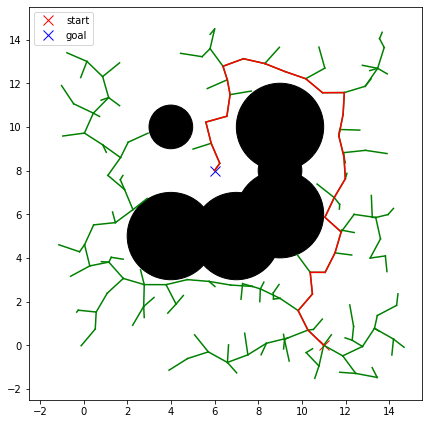

In [ ]:
np.random.seed(7)
rrt = RRT_tree(start, goal, bounds, obstacles)
path = find_path(rrt, start, goal)

plt.figure(figsize=(6,6))
plot_scene(obstacles, start, goal)
draw_graph(rrt)
if rrt is None:
  print("No viable path found")
else:
  if path is not None:
    plt.plot([x for (x, y) in path], [y for (x, y) in path], '-r')
plt.tight_layout()

## **Can we do better?**
We're not going to be tackling RRT* today, but we can improve our current RRT function a bit on runtime! The best way for us to do this is to change how we're sampling points within the bounds of our environment. 

Our current `get_random_node` function is below. We can build off this function, but we're going to add something else as well.

```python
def get_random_node(bounds):
  """Sample random node inside bounds or sample goal point"""
  rnd = np.random.rand(2)*(bounds[1]-bounds[0]) + bounds[0]
  return tuple(rnd)
```

We'll be writing the `get_random_node_sg(bounds, goal, goal_sample_rate)` function, which will mostly behave like the `get_random_node` function. The main difference is that depending on the goal sample rate, sometimes instead of returning a random point, we'll return the goal point.

So if `goal_sample_rate` was set to 0.3, then 30% of the time we would return `goal`.

Go ahead and write this function below!

**HINT**: you might want to check out the documentation for `random.random()` [here](https://docs.python.org/3/library/random.html#random.random).

In [ ]:
import random

In [ ]:
def get_random_node_sg(bounds, goal, goal_sample_rate):
  """Sample random node inside bounds or sample goal point"""
  if random.random() < goal_sample_rate:
    return goal
  rnd = np.random.rand(2)*(bounds[1]-bounds[0]) + bounds[0]
  return tuple(rnd)

Once you've finished this function, replace `get_random_node` in your `RRT_tree` function above and re-run it. When you're adding your new function to `RRT_tree`, you get to choose the `goal_sample_rate`. What do you think is a good number? 

**What do you notice is different about the path and the tree?**

## **Try to sample in a different way!**
What are some other ways we could sample that would help speed up our search algorithm? **If you have time left over,** try to write a new sampling algorithm below to use in your problem.

In [ ]:
def RRT_star(start, end, bounds, obstacle_list, max_iter = 500, max_extend_length=1.0):
  '''
  Returns the tree created by RRT. Shouldn't build the tree anymore once a path can be made to the goal
  The tree should be formatted as the came_from dictionary where you're mapping children to their parents
  '''
  # initialize the node list and came from dict
  node_list = [start]
  came_from = {start:None}
  cost = {}
  # loop until no more iterations
  for i in range(max_iter):
    # get a random node
    randNode = get_random_node(bounds)
    # find the closest node to that node
    nearNode = get_nearest_node(node_list,randNode)
    # steer from the closest node in the direction of the random node
    steerNode = steer(nearNode,randNode,max_extend_length)
    # if there's no collision between steered node and closest node
    if not(is_collision(nearNode,steerNode,obstacle_list)):
      # add it to node list and came from
      node_list.append(steerNode)
      newNearNode = get_nearest_node(node_list,steerNode)
      came_from[steerNode] = newNearNode
      # if this new node is less than max_extend_length to the goal
      if abs(dist_to_goal(steerNode,end)) < max_extend_length:
        # if there is no collision between the new node and goal node
        if not(is_collision(steerNode,end,obstacle_list)):
          # add it to node list and came from
          node_list.append(end)
          came_from[end] = steerNode
          # return the came from dict
          return came_from
  return None

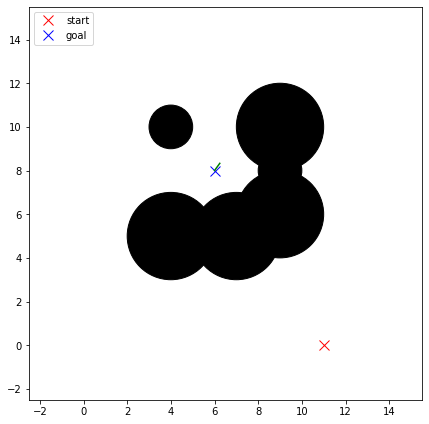

In [ ]:
np.random.seed(7)
rrt = RRT_star(start, goal, bounds, obstacles)

plt.figure(figsize=(6,6))
plot_scene(obstacles, start, goal)
draw_graph(rrt)
if rrt is None:
    print("No viable path found")
plt.tight_layout()

# **That's it! You've finished this coding assignment.**

## Make sure you check in with your instructor once you're done to check off the notebook!